In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, GridSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar


## **Load data**

In [49]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [50]:
X_train.shape

(50000, 32, 32, 3)

In [51]:
X_test.shape

(10000, 32, 32, 3)

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
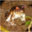

In [52]:
X_train[0]

In [53]:
classes= ['airplane', 'automobile', 'bird','cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

In [54]:
y_test.shape

(10000, 1)

In [55]:
y_test.reshape(-1,)

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

In [56]:
y_test.shape

(10000, 1)

In [57]:
def plot_single_sample(X,y,index):
  plt.figure(figsize=(14,2))
  plt.imshow(X[index])
  plt.xlabel(classes[y[index]])

In [58]:
# plot_single_sample(X_train,y_train, 1)

# **# data preprocessing**

In [59]:
# Normalize pixel values to range [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

In [60]:
# Select a subset (20%) of the training data for augmentation
subset_size = int(0.2 * len(X_train))
X_train_subset, y_train_subset = X_train[:subset_size], y_train[:subset_size]

# Data Augmentation for only 20% of training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

train_datagen.fit(X_train_subset)

# The remaining 80% of the training data will be used without augmentation
X_train_no_augmentation = X_train[subset_size:]
y_train_no_augmentation = y_train[subset_size:]

# Combine the augmented data and non-augmented data

X_train = np.concatenate([X_train_subset, X_train_no_augmentation], axis=0)
y_train = np.concatenate([y_train_subset, y_train_no_augmentation], axis=0)


print(f"Total training samples after augmentation: {X_train.shape[0]}")


Total training samples after augmentation: 50000


# **# Model Architecture**

In [60]:
model = models.Sequential([

    # First CNN Layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', strides=1, input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second CNN Layer
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', strides=1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third CNN Layer
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', strides=1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten the feature maps before passing to Dense layers
    layers.Flatten(),

    # Fully Connected Layer
    layers.Dense(512, activation='relu'),

    # Dropout for regularization
    layers.Dropout(0.2),  # Corrected from 20 to 0.2

    # Output Layer (Softmax for multi-class classification)
    layers.Dense(10, activation='softmax')  # Assuming 10 classes
])

# Print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,148,362 (4.38 MB)

 Trainable params: 1,147,914 (4.38 MB)

 Non-trainable params: 448 (1.75 KB)

# **# Hyperparameter Tuning**

In [61]:
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
import numpy as np

# Custom wrapper for the Keras model
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, dropout_rate=0.2, num_layers=3, learning_rate=1e-3, optimizer='adam',
                 batch_size=32, epochs=3):
        self.dropout_rate = dropout_rate
        self.num_layers = num_layers  # Set to 3 layers by default
        self.learning_rate = learning_rate
        self.optimizer = optimizer  # Optimizer is now part of the search grid
        self.batch_size = batch_size
        self.epochs = epochs

    def create_model(self):
        model = models.Sequential()

        # Use HeNormal initializer
        initializer = HeNormal()

        # Add convolutional layers with 3 layers
        for i in range(self.num_layers):
            filters = 32 * (2 ** i)  # Increase number of filters with each layer
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same', strides=1,
                                    kernel_initializer=initializer, input_shape=(32, 32, 3) if i == 0 else None))
            model.add(layers.BatchNormalization())
            model.add(layers.MaxPooling2D((2, 2)))

        # Flatten the feature maps before passing to Dense layers
        model.add(layers.Flatten())

        # Fully Connected Layer
        model.add(layers.Dense(512, activation='relu', kernel_initializer=initializer))

        # Dropout for regularization (20% dropout)
        model.add(layers.Dropout(self.dropout_rate))

        # Output Layer (Softmax for multi-class classification)
        model.add(layers.Dense(10, activation='softmax'))

        # Choose optimizer based on the passed parameter (Adam by default)
        if self.optimizer == 'adam':
            optimizer = Adam(learning_rate=self.learning_rate)
        elif self.optimizer == 'sgd':
            optimizer = SGD(learning_rate=self.learning_rate)


        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y, validation_data=None, **kwargs):  # Accept validation_data as a parameter
        self.model = self.create_model()
        # Use the validation_data parameter if it's provided
        return self.model.fit(X, y, validation_data=validation_data, **kwargs)

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  # Return accuracy


# Create a GridSearchCV instance with updated parameters
param_grid = {
    'learning_rate': [0.003, 0.004,0.005],  # Explore learning rates
    'batch_size': [32, 64],  # Explore batch sizes
    'optimizer': ['adam', 'sgd']  # Include optimizer in search grid
}

# Create the custom Keras model wrapper
model = KerasModelWrapper()



AttributeError: 'KerasModelWrapper' object has no attribute 'summary'

In [62]:
# Create a GridSearchCV instance
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=11, cv=10)

# Fit the model using GridSearchCV
grid_result = grid.fit(X_train, y_train)

# Print the best result
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.4277 - loss: 1.8880
Best: 0.5468000084161758 using {'batch_size': 32, 'learning_rate': 0.003, 'optimizer': 'adam'}


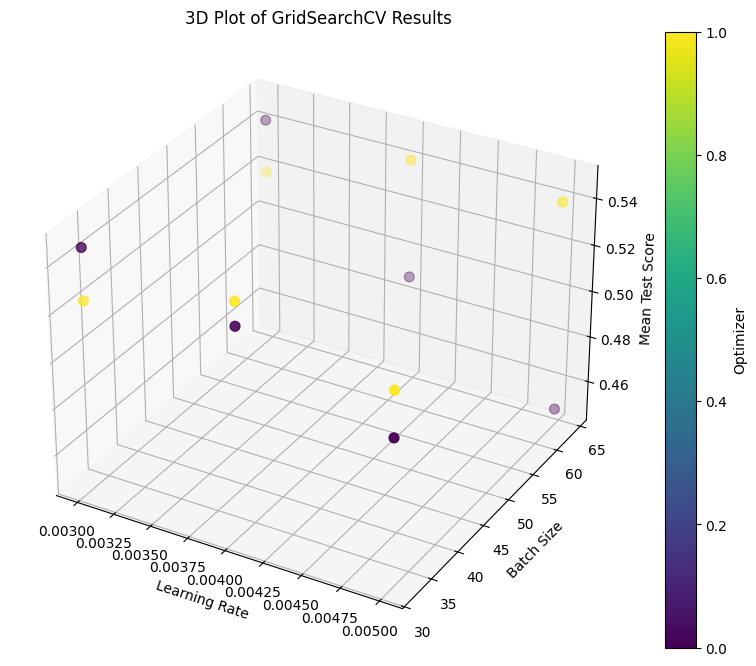

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Extract the results into a DataFrame
results_df = pd.DataFrame(grid_result.cv_results_)

# Get the values of hyperparameters and mean test scores
learning_rates = results_df['param_learning_rate']
batch_sizes = results_df['param_batch_size']
optimizers = results_df['param_optimizer']
mean_test_scores = results_df['mean_test_score']

# Create a figure for the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Convert optimizer to a numerical value for plotting
optimizer_map = {'adam': 0, 'sgd': 1}
optimizer_values = optimizers.map(optimizer_map)

# Create a 3D scatter plot
scatter = ax.scatter(learning_rates, batch_sizes, mean_test_scores, c=optimizer_values, cmap='viridis', s=50)

# Label the axes
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Mean Test Score')

# Add a color bar to indicate the optimizer
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Optimizer')

# Title for the plot
ax.set_title('3D Plot of GridSearchCV Results')

# Show the plot
plt.show()


In [65]:
#create validation data
# Select 5% of the training data for validation
validation_size = int(0.05 * len(X_train))
X_val, y_val = X_train[:validation_size], y_train[:validation_size]

# Use the remaining 95% for training
X_train, y_train = X_train[validation_size:], y_train[validation_size:]


# Select a subset (20%) of the training data for augmentation
subset_size = int(0.2 * len(X_train))
X_train_subset, y_train_subset = X_train[:subset_size], y_train[:subset_size]

# Data Augmentation for only 20% of training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

train_datagen.fit(X_train_subset)

# The remaining 80% of the training data will be used without augmentation
X_train_no_augmentation = X_train[subset_size:]
y_train_no_augmentation = y_train[subset_size:]

# Combine the augmented data and non-augmented data

X_train = np.concatenate([X_train_subset, X_train_no_augmentation], axis=0)
y_train = np.concatenate([y_train_subset, y_train_no_augmentation], axis=0)


print(f"Total training samples after augmentation: {X_train.shape[0]}")


Total training samples after augmentation: 47500


In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Train the model with the best parameters and early stopping
best_model = KerasModelWrapper(
    dropout_rate=0.2,  # Fixed dropout rate of 20%
    num_layers=3,  # Fixed number of layers to 3
    learning_rate=grid_result.best_params_['learning_rate'],  # Best learning rate from GridSearchCV
    optimizer=grid_result.best_params_['optimizer'],  # Best optimizer from GridSearchCV
    batch_size=grid_result.best_params_['batch_size'],  # Best batch size from GridSearchCV
    epochs=50  # Set epochs as needed
)



Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_233 (Conv2D)                  │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_233              │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_233 (MaxPooling2D)     │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_234 (Conv2D)                  │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_234              │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_234 (MaxPooling2D)     │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_235 (Conv2D)                  │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_235              │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_235 (MaxPooling2D)     │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_91 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_182 (Dense)                    │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,148,362 (4.38 MB)

 Trainable params: 1,147,914 (4.38 MB)

 Non-trainable params: 448 (1.75 KB)

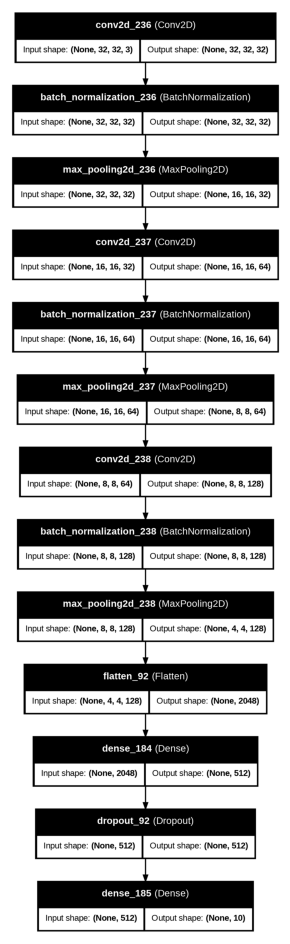

In [87]:
from tensorflow.keras.utils import plot_model

# Print the architecture of the model
best_model.create_model().summary()  # This will print the architecture summary to the console

# Plot the model architecture to a file (e.g., 'model_architecture.png')
plot_model(best_model.create_model(), to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot model (optional)
img = plt.imread('model_architecture.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [83]:
# Set early stopping to monitor validation loss and stop training early if it stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Track the test loss and accuracy during training
test_loss_list = []
test_accuracy_list = []

# Train the model using the best parameters found by GridSearchCV
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1,  # Display training progress
    epochs=50
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4074 - loss: 1.9833 - val_accuracy: 0.5196 - val_loss: 1.4152
Epoch 2/50
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6359 - loss: 1.0542 - val_accuracy: 0.6816 - val_loss: 0.9139
Epoch 3/50
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7086 - loss: 0.8433 - val_accuracy: 0.5800 - val_loss: 1.3584
Epoch 4/50
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7462 - loss: 0.7268 - val_accuracy: 0.6588 - val_loss: 1.0444
Epoch 5/50
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7886 - loss: 0.6209 - val_accuracy: 0.7396 - val_loss: 0.7778
Epoch 6/50
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8164 - loss: 0.5356 - val_accuracy: 0.6968 - val_loss: 0.9732
Epoch 7/50
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8361 - loss: 0.4741 - val_accuracy: 0.7664 - val_loss: 0.8080
Epoch 8/50
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8642 - loss: 0.3954 -

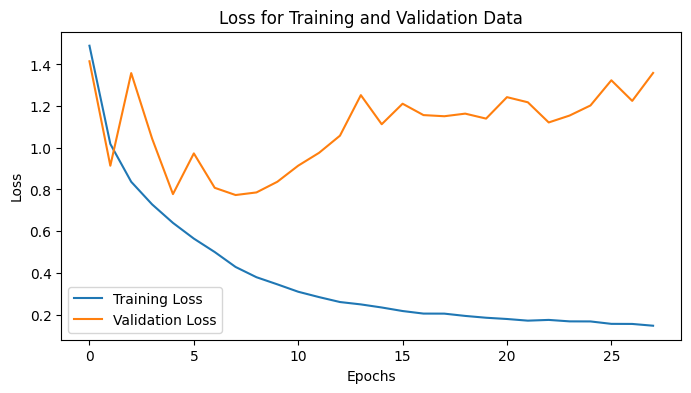

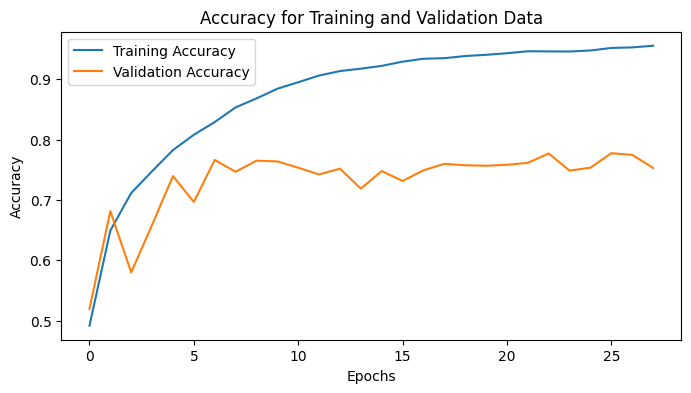

Test Accuracy: 0.7430
Final Training Accuracy: 0.9557
Final Validation Accuracy: 0.7532


In [86]:
# Plot the training and validation loss during training
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss for Training and Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy during training
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy for Training and Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set to get the accuracy
test_accuracy = best_model.score(X_test, y_test)  # Only get accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print the final training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")